In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

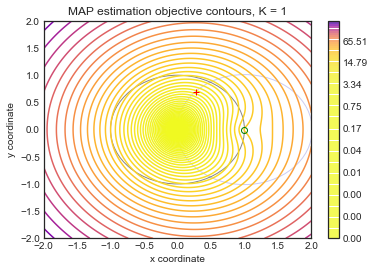

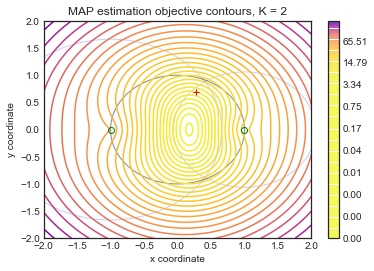

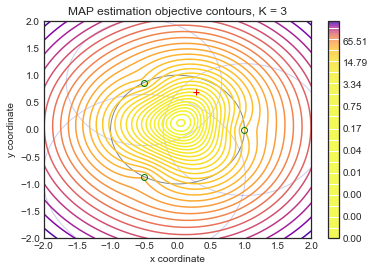

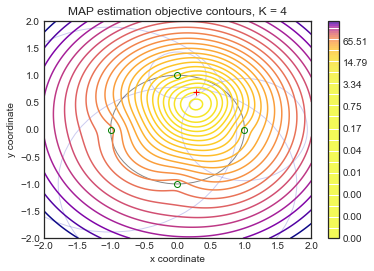

In [1]:
#!/usr/bin/env python3

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

SIGMA_X = 0.25
SIGMA_Y = 0.25
SIGMA_I = 0.3

CONTOUR_LEVELS = np.geomspace(0.0001, 250, 100)

# Returns a random xy pair within the unit circle centered at the origin.
def random_unit_circle_coords():
    # Polar coordinates with a square-rooted r-value produce a uniform distribution
    r = np.sqrt(np.random.uniform(0, 1))
    theta = np.random.uniform(0, 2) * np.pi
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.array([x, y])

# Generates noisy measurements for all K landmarks given the true position.
def get_range_measurements(K, xy_true):
    return [generate_measurement(landmark_pos(i, K), xy_true) for i in range(K)]

# Returns the xy coordinate pair of the i'th landmark out of K total landmarks.
def landmark_pos(i, K):
    angle = 2 * np.pi / K * i
    x = np.cos(angle)
    y = np.sin(angle)
    return np.array([x, y])

# Generates a range measurement between the given landmark and true positions,
# with random Gaussian noise.
def generate_measurement(xy_landmark, xy_true):
    dTi = np.linalg.norm(xy_true-xy_landmark)
    while True:
        noise = np.random.normal(0, SIGMA_I)
        measurement = dTi + noise
        if measurement >= 0:
            return measurement

# Creates an equilevel contour plot for the MAP estimation objective function
# given a set of range measurements
def plot_equilevels(range_measurements, xy_true):
    # First, create a mesh grid of values from the objective function
    gridpoints = np.meshgrid(np.linspace(-2, 2, 128), np.linspace(-2, 2, 128))
    contour_values = MAP_objective(gridpoints, range_measurements)

    # Then, set up the plot
    plt.style.use('seaborn-white')

    ax = plt.gca()

    unit_circle = plt.Circle((0, 0), 1, color='#888888', fill=False)
    ax.add_artist(unit_circle)

    plt.contour(gridpoints[0], gridpoints[1], contour_values, cmap='plasma_r', levels=CONTOUR_LEVELS);

    for (i, r_i) in enumerate(range_measurements):
        (x, y) = landmark_pos(i, len(range_measurements))
        plt.plot((x), (y), 'o', color='g', markerfacecolor='none')
        # I added faint blue circles to demonstrate the range from each landmark
        range_circle = plt.Circle((x, y), r_i, color='#0000bb33', fill=False)
        ax.add_artist(range_circle)

    ax.set_xlabel("x coordinate")
    ax.set_ylabel("y coordinate")
    ax.set_title("MAP estimation objective contours, K = " + str(len(range_measurements)))

    ax.set_xlim((-2, 2))
    ax.set_ylim((-2, 2))
    ax.plot([xy_true[0]], [xy_true[1]], '+', color='r')
    plt.colorbar();
    plt.show()

# Calculates values of the MAP estimation objective function on a given mesh
# grid of input x-y coordinate pairs.
def MAP_objective(xy, range_measurements):
    # The shape of xy is (2, n, m), but it needs to be (n, m, 1, 2).
    xy = np.expand_dims(np.transpose(xy, axes=(1, 2, 0)), axis=len(np.shape(xy))-1)

    prior = np.matmul(xy, np.linalg.inv(np.array([[SIGMA_X**2, 0],[0, SIGMA_Y**2]])))
    prior = np.matmul(prior, np.swapaxes(xy, 2, 3))
    prior = np.squeeze(prior)
    # prior is now of shape (n, m).

    range_sum = 0

    for (i, r_i) in enumerate(range_measurements):
        xy_i = landmark_pos(i, len(range_measurements))
        d_i = np.linalg.norm(xy - xy_i[None, None, None, :], axis=3)
        range_sum += np.squeeze((r_i - d_i)**2 / SIGMA_I**2)

    return prior + range_sum


xy_true = random_unit_circle_coords()

for K in [1, 2, 3, 4]:
    range_measurements = get_range_measurements(K, xy_true)
    plot_equilevels(range_measurements, xy_true)


In [6]:
features= 2
s1=20
s2=200
s3=2000
s4=10000

prior=[0.65, 0.35]
mean0= np.zeros((features, 2))

#one guassian mixture dist for class 0
mean0[:,:]= 3*np.eye(2)

#one guassian dist for class 1
mean1=np.zeros((features,1))
mean1[:,0]= [2,2]

cov=np.zeros((features,features,3))
cov[:,:,0]= [[2,0],
             [0,1]]
cov[:,:,1]= [[1,0],
             [0,2]]
cov[:,:,2]= np.eye(2)

In [64]:
mean0.shape

(2, 2)

In [8]:
def generate_labels(samples,prior):
    label=np.zeros(samples)
    label[:]=(np.random.uniform(0,1,samples) >= prior[0]).astype(int)    
    return label

labels20=generate_labels(s1,prior)
labels200=generate_labels(s2,prior)
labels2k=generate_labels(s3,prior)
labels10k=generate_labels(s4,prior)

In [15]:
#prior after random labels
NC10k= [(sum(labels10k==0))/10000, (sum(labels10k==1))/10000 ]
NC20= [sum(labels20==0)/20, sum(labels20==1)/20]
NC200= [sum(labels200==0)/200, sum(labels200==1)/200]
NC2k= [sum(labels2k==0)/2000, sum(labels2k==1)/2000]


In [23]:
def create_data(mean0,mean1,cov,samples, label):
    X=np.zeros((features,samples))

    for i in range(samples):
        if label[i]==0:
            X[:,i] =0.5*np.random.multivariate_normal(mean0[:,0],cov[:,:,0],1) + 0.5*np.random.multivariate_normal(mean0[:,1],cov[:,:,1],1)
        else:
            X[:,i] =np.random.multivariate_normal(mean1[:,0],cov[:,:,2],1)
    return X

X20=create_data(mean0,mean1,cov,s1, labels20)
X200=create_data(mean0,mean1,cov,s2, labels200)
X2k=create_data(mean0,mean1,cov,s3, labels2k)
X10k=create_data(mean0,mean1,cov,s4, labels10k)

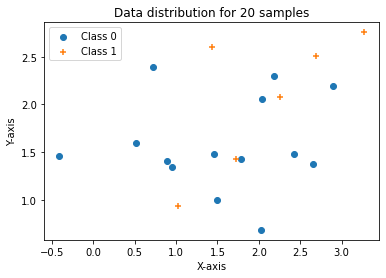

In [25]:
def plot_data_dist(X,label):
    x0 = [i for i in range(X.shape[1]) if (label[i] == 0)]
    x1 = [i for i in range(X.shape[1]) if (label[i] == 1 )]
    fig = plt.figure()
    x=X[0,x0]
    y=X[1,x0]

    X1=X[0,x1]
    y1=X[1,x1]
 
    plt.scatter(x, y,marker='o')
    plt.scatter(X1, y1,marker='+')

    plt.title("Data distribution for {0} samples".format(X.shape[1]))
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(['Class 0','Class 1'])
    plt.show()
    
plot_data_dist(X20, labels20)

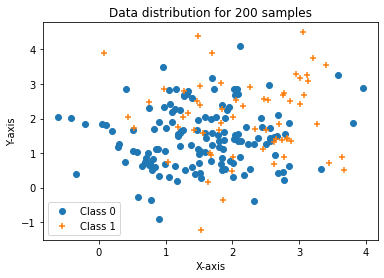

In [26]:
plot_data_dist(X200, labels200)

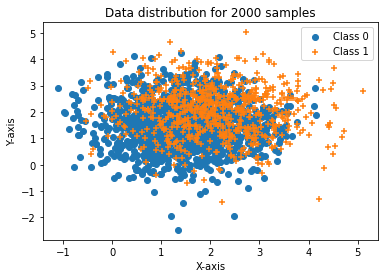

In [27]:
plot_data_dist(X2k, labels2k)

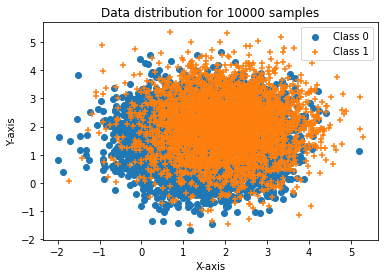

In [28]:
plot_data_dist(X10k, labels10k)

In [102]:
def evalGuassPDF(X,mu,sigma):
    n=X.shape[0]
    N=X.shape[1]
    C= (2*np.pi) ** (-n/2) *np.linalg.det(np.linalg.inv(sigma)) ** (1/2)
    a=X-mu[:,np.newaxis]
    b=np.dot(np.linalg.inv(sigma),a)
    px= C* np.exp(-0.5 * np.sum(a*b,axis=0))
    return px

def compute_discriminant_score(X,mean0,mean1,cov): #log-liklihood-ratio 
    
    log_pdf1=np.log(mvn.pdf(X.T,mean=mean1[:,0], cov=cov[:,:,2]))
    log_pdf0=np.log (0.5*(mvn.pdf(X.T,mean=mean0[:,0], cov=cov[:,:,0]) + 
                          mvn.pdf(X.T,mean=mean0[:,1], cov=cov[:,:,1])))
    disc_score=2*(log_pdf1.T - log_pdf0.T)
    
    return disc_score

def compute_gamma(disc_score): #derivative
    ds=np.sort(disc_score)
    eps=np.spacing(1)
    return [(ds[i]-eps) for i in range(s4)]

# def compute_gamma_mid_point(gamma):
#     mid_gamma= []
#     for i in range(len(gamma)-1):
#         avg=(gamma[i]-gamma[i+1]) /2.0
#         mid_gamma.append((gamma[0]) * gamma[i]  + avg * (gamma[-1] ))
#     return mid_gamma

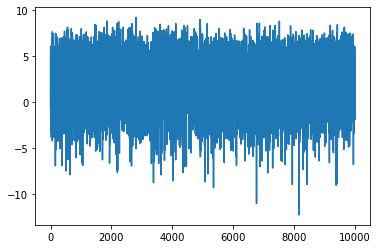

In [103]:
DS10k=compute_discriminant_score(X10k,mean0,mean1, cov)
plt.plot((DS10k))

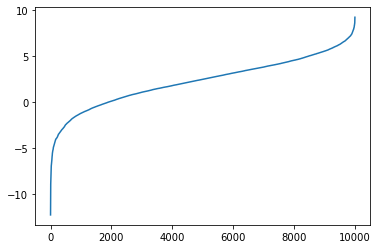

In [104]:
gamma10k=compute_gamma(DS10k)
plt.plot((gamma10k))
plt.show()

In [155]:
def count_positives(disc_score,gamma_val, label):
    p10=0;p11=0
    decision=((disc_score)>=(gamma_val)).astype(int)
    #label=np.sort(label)
    for i in range(len(decision)):
        if decision[i] ==1 and label[i] == 0:
            p10+=1
        elif decision[i] ==1 and label[i]== 1:
            p11+=1
    #print(p10,p11)
    return p10,p11
        
def compute_prob_error(gamma,disc_score,label,NC,prior,samples):
    Perr=[]
    False_pos_rate=[]
    True_pos_rate=[]
    for j in range(len(disc_score)):
        p10,p11=count_positives(disc_score,gamma, label)
        
        True_pos_rate.append(p11/ NC[1]/10000)
        False_pos_rate.append(p10 / NC[0]/10000)
        
        perr= (False_pos_rate[j] * prior[0]) + ( (1- True_pos_rate[j]) * prior[1])
        Perr.append(perr)
        
    return Perr #True_pos_rate, False_pos_rate,

#TPR, FPR, Prob_err= compute_prob_error(gamma10k,DS10k,labels10k,NC10k,prior,s4)
#plt.plot(FPR,TPR)

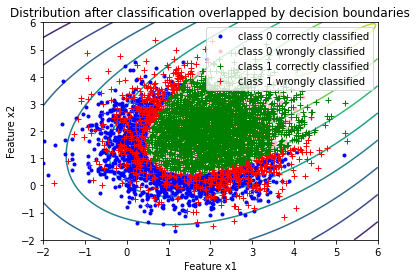

In [95]:
# Code to plot contours of the distribution after Classification with true labels
decision=np.zeros((s4))
X=X10k
decision = (DS10k >= np.log(1.86)).astype(int)

x00 = [i for i in range(s4) if (labels10k[i] == 0 and decision[i] == 0)]
x01 = [i for i in range(s4) if (labels10k[i] == 0 and decision[i] == 1)]
x10 = [i for i in range(s4) if (labels10k[i] == 1 and decision[i] == 0)]
x11 = [i for i in range(s4) if (labels10k[i] == 1 and decision[i] == 1)]

plt.plot(X[0,x00],X[1,x00],'.',color ='b', markersize = 6)
plt.plot(X[0,x01],X[1,x01],'.',color = 'pink', markersize = 6)
plt.plot(X[0,x11],X[1,x11],'+',color ='g', markersize = 6)
plt.plot(X[0,x10],X[1,x10],'+',color = 'r', markersize = 6)
plt.legend(["class 0 correctly classified",'class 0 wrongly classified','class 1 correctly classified','class 1 wrongly classified'])
plt.xlabel("Feature x1")
plt.ylabel("Feature x2")
plt.title('Distribution after classification overlapped by decision boundaries')

horizontalGrid = np.linspace(np.floor(min(X[0,:])),np.ceil(max(X[0,:])),100)
verticalGrid = np.linspace(np.floor(min(X[1,:])),np.ceil(max(X[1,:])),100);
dsg = np.zeros((100,100))
a = np.array(np.meshgrid(horizontalGrid,verticalGrid))
for i in range(100):
    for j in range(100):
        p = 0.5*mvn.pdf(np.array([a[0][i][j], a[1][i][j]]),mean=mean0[:,1], cov = cov[:,:,1])+0.5*mvn.pdf(np.array([a[0][i][j], a[1][i][j]]),mean=mean0[:,0], cov = cov[:,:,0])
        q = mvn.pdf(np.array([a[0][i][j], a[1][i][j]]),mean=mean1[:,0], cov = cov[:,:,2])
        dsg[i][j] = np.log(q) - np.log(p) - np.log(1.86)
plt.contour(a[0],a[1],dsg)
plt.show()

In [89]:
# minimum probability of error 
def estimate_MPE_prop(Prob_err,mid_gamma,disc_score,False_pos_rate, True_pos_rate):
    min_idx_gamma=np.argmin(Prob_err)
    optimal_gamma= mid_gamma[min_idx_gamma]
    min_perr= Prob_err[min_idx_gamma]

#     min_decision= (disc_score >=optimal_gamma) 
    min_False_pos_rate= False_pos_rate[min_idx_gamma]
    min_True_pos_rate= True_pos_rate[min_idx_gamma]
    
    return optimal_gamma,min_perr,min_False_pos_rate,min_True_pos_rate

optimal_gamma,min_perr,min_False_pos_rate,min_True_pos_rate =estimate_MPE_prop(Prob_err,gamma10k,DS10k,FPR, TPR)

#Ideal minimum probability of error 
ideal_fp, ideal_tp= count_positives(DS10k, np.log(prior[0]/ prior[1]), labels10k)

# ideal_decision= (DS10k > np.log(prior[0]/ prior[1]) )
ideal_fpr=ideal_fp/NC10k[0]
ideal_tpr=ideal_tp/NC10k[1]

ideal_err= (ideal_fpr*prior[0] + ((1-ideal_tpr) * prior[1]))

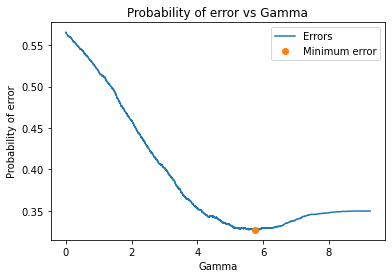

In [90]:
plt.plot( gamma10k, Prob_err)
plt.plot(optimal_gamma,min_perr, 'o')
plt.xlabel('Gamma')
plt.ylabel('Probability of error')
plt.legend(['Errors','Minimum error'])
plt.title('Probability of error vs Gamma')
plt.show()

 Ideal error : 187838.466%, Ideal Gamma : 1.857 
 Min error : 32.705%, Calc. Gamma : 5.748 


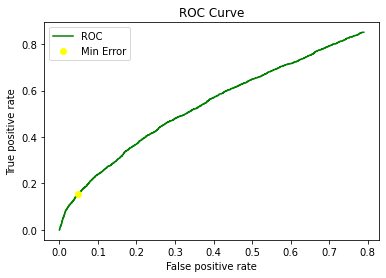

Min P(e) = 0.327
TPR = 0.16
FPR = 0.05


In [93]:
plt.plot(FPR,TPR,color='green')
plt.plot(min_False_pos_rate, min_True_pos_rate,'o',color='yellow')
# plt.plot(ideal_fpr,ideal_tpr,'x',color='red')

print(f' Ideal error : {ideal_err*100 :.3f}%, Ideal Gamma : {prior[0]/ prior[1] :.3f} ')
print(f' Min error : {min_perr*100 :.3f}%, Calc. Gamma : {(optimal_gamma) :.3f} ' )

plt.legend(['ROC','Min Error','Ideal Error'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

print('Min P(e) = ' + str(round(Prob_err[np.argmin(Prob_err)],3)) + '\n'
 +'TPR = '+ str(round(TPR[np.argmin(Prob_err)],2)) + '\n' 
 +'FPR = '+ str(round(FPR[np.argmin(Prob_err)],2)))


# ML parameter estimation

In [156]:
def find_theta(train_data,alpha,iterations,train_labels,test_data, type_ = 'l'):
    if(type_ == 'l'): #linear model
        z = np.c_[np.ones((train_data.shape[1])),train_data.T].T #basis vector
        w = np.zeros((3,1)) #weights vector -->theta
    else: #quadratic model
        z = np.c_[np.ones((train_data.shape[1])),train_data[0],train_data[1],train_data[0]*train_data[0],train_data[0]*train_data[1], train_data[1]*train_data[1]].T
        w = np.zeros((6,1))

    for i in range(iterations): #design h-model
        h = 1/ (1+ np.exp(-(np.dot(z.T,w))))
        y=train_labels
        cost_gradient= (-1/len(h))* np.sum(np.dot(y.T,np.log(h)) + np.dot((1-y).T,np.log(1-h)) )
        #print(h.shape,cost_gradient.shape)
        w = w - alpha*cost_gradient

#     if(type_ == 'l'):
#         x= np.c_[np.ones((test_data.shape[1])),test_data.T].T
#     else:
#         x = np.c_[np.ones((test_data.shape[1])),test_data[0],test_data[1],test_data[0]*test_data[0],test_data[0]*test_data[1], test_data[1]*test_data[1]].T
    
#     decisions = np.zeros((1,test_data.shape[1]))
#     hmodel = 1/ (1+np.exp(-(np.dot(w.T,z))))
#     decisions[0,:] = (h[0,:]>=0.5).astype(int)
        
    DS= np.c_[np.ones((test_data.shape[1])), test_data.T ].T
    g=0
    prob=compute_prob_error(g,DS,labels10k,NC10k,prior,test_data.shape[1])
    return(w,decisions)



In [ ]:
w20, d20 = find_theta(X20,0.01,1000,labels20,X10k)
w200, d200 = find_theta(X200,0.05,1000,labels200,X10k)
w2k, d2k = find_theta(X2k,0.05,1000,labels2k,X10k)

In [48]:
for decisions in [d20,d200,d2k]:
    x00 = [i for i in range(10000) if (labels10k[i] == 0 and decisions[0,i] == 0)]
    x11 = [i for i in range(10000) if (labels10k[i] == 1 and decisions[0,i] == 1)]
    print(100 - ((len(x00)+len(x11))/100.0))

34.379999999999995
34.379999999999995
65.57


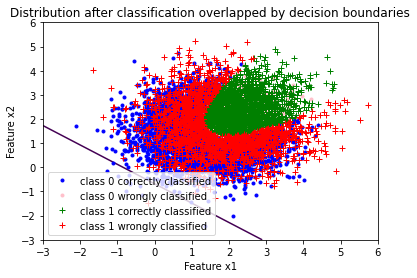

In [96]:
def plot_boundary(labels):
    X = X10k
    # z = np.c_[np.ones((train_data.shape[1])),train_data.T].T
    # h = 1/ (1+np.exp(-(np.dot(w100.T,z))))

    #decisions[0,:] = (h[0,:]>=0.5).astype(int)
    x00 = [i for i in range(s4) if (labels[i] == 0 and decision2[i] == 0)]
    x01 = [i for i in range(s4) if (labels[i] == 0 and decision2[i] == 1)]
    x10 = [i for i in range(s4) if (labels[i] == 1 and decision2[i] == 0)]
    x11 = [i for i in range(s4) if (labels[i] == 1 and decision2[i] == 1)]
    plt.plot(X[0,x00],X[1,x00],'.',color ='b', markersize = 6)
    plt.plot(X[0,x01],X[1,x01],'.',color = 'pink', markersize = 6)
    plt.plot(X[0,x11],X[1,x11],'+',color ='g', markersize = 6)
    plt.plot(X[0,x10],X[1,x10],'+',color = 'r', markersize = 6)
    plt.legend(["class 0 correctly classified",'class 0 wrongly classified','class 1 correctly classified','class 1 wrongly classified'])
    plt.xlabel("Feature x1")
    plt.ylabel("Feature x2")
    plt.title('Distribution after classification overlapped by decision boundaries')
    
    # plot_data(X,10,labels_10)
    horizontalGrid = np.linspace(np.floor(min(X[0,:])),np.ceil(max(X[0,:])),100);
    verticalGrid = np.linspace(np.floor(min(X[1,:])),np.ceil(max(X[1,:])),100);
    dsg = np.zeros((100,100))
    a = np.array(np.meshgrid(horizontalGrid,verticalGrid))
    for i in range(100):
        for j in range(100):
            x1 = a[0][i][j]
            x2 = a[1][i][j]
            z = np.c_[1,x1,x2].T
            dsg[i][j] = np.sum(np.dot(w20.T,z))

    plt.contour(a[0],a[1],dsg, levels = [0])
    plt.show()
plot_boundary(np.vstack((labels10k,d20.T)))

In [113]:
from sklearn.mixture import GaussianMixture as Gmm 
def estimate_parameters(x,mean0,mean1):
    s=x.shape[1]
    gmm0=Gmm(n_components=2,covariance_type='full',means_init=(mean0[:,0]).reshape(2,1) )
    gmm0.fit(x[0,:].reshape(s,1))

    gmm01=Gmm(n_components=2,covariance_type='full',means_init=(mean0[:,1]).reshape(2,1) )
    gmm01.fit(x[0,:].reshape(s,1))

    gmm1=Gmm(n_components=2,means_init=mean1.reshape(2,1))
    gmm1.fit(np.reshape(x[1,:], (s,1)))
    
    return gmm0,gmm01,gmm1

In [116]:
gmm0_20,gmm01_20,gmm1_20= estimate_parameters(X20,mean0,mean1)
gmm0_200,gmm01_200,gmm1_200= estimate_parameters(X200,mean0,mean1)
gmm0_2k,gmm01_2k,gmm1_2k= estimate_parameters(X2k,mean0,mean1)

gmm0_20.means_,gmm0_20.covariances_.shape,#gmm0.weights_,gmm0.precisions_,gmm0.lower_bound_

(array([[2.16440994],
        [0.87273273]]),
 (2, 1, 1))

In [115]:
gmm01_20.means_,gmm1_20.means_

(array([[0.85279107],
        [2.14916016]]),
 array([[1.86751001],
        [1.67146231]]))

In [ ]:
def plotContours(X,w,prior):
    plt.plot(X[0,:], X[1,:])
    
    horizontalGrid = np.linspace(np.floor(min(X[0,:])),np.ceil(max(X[0,:])),100);
    verticalGrid = np.linspace(np.floor(min(X[1,:])),np.ceil(max(X[1,:])),100);
    dsg = np.zeros((100,100))
    a = np.array(np.meshgrid(horizontalGrid,verticalGrid))
    for i in range(100):
        for j in range(100):
            x1 = a[0][i][j]
            x2 = a[1][i][j]
            z = np.c_[1,x1,x2].T
            dsg[i][j] = np.sum(np.dot(w.T,z))

    plt.contour(a[0],a[1],dsg, levels = [0])
    plt.show()
    
plotContours(X20,w20,NC20)